In [3]:
import pandas as pd
import sklearn as sk
from sklearn import model_selection
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

df = pd.read_csv('hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv')
# Shuffle the dataset randomly to avoid any bias from alphabetical order
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Remove duplicates based on 'track_id' and 'track_name', keeping only the first occurrence
df_remove_duplicates = df_shuffled.drop_duplicates(subset=['track_id', 'track_name'], keep='first')

# Now, we no longer need these variables
drop_columns = ['Unnamed: 0', 'track_id', 'artists', 'track_name', 'album_name']
df = df_remove_duplicates.drop(columns=drop_columns).reset_index(drop=True)

# Step 1: Identify the top 50 genres by frequency
top_genres = df["track_genre"].value_counts().head(40).index

# Step 2: Filter the dataframe to include only rows with top genres
df = df[df["track_genre"].isin(top_genres)]

#create one-hot encodings for inordinal categorical variables
X = df.drop(['track_genre'], axis=1)
X = pd.get_dummies(X, columns=['explicit', 'key', 'mode', 'time_signature'], drop_first=True, dtype=int)

In [ ]:
#train test split and scale
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, df['track_genre'], train_size=0.8)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
#initial random forest without hyperparameter tuning
randomForest = RandomForestClassifier(random_state=8743, n_estimators=50)
randomForest.fit(x_train, y_train)
y_pred = randomForest.predict(x_test)
y_test.to_numpy()
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6209593326381647

In [ ]:
#hyperparameter tuning for random forest
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5, 7, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(x_train, y_train)

bestRF = grid_search.best_estimator_
bestRF

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
0.6287110966270164


In [ ]:
#test on hyperparameter-tuned random forest classifier
bestRF = grid_search.best_estimator_
y_pred = bestRF.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6322992700729927

Classification Report:
                precision    recall  f1-score   support

      afrobeat       0.49      0.44      0.46       208
   black-metal       0.65      0.80      0.72       179
     bluegrass       0.55      0.72      0.62       196
     breakbeat       0.64      0.56      0.60       202
      cantopop       0.43      0.44      0.43       180
 chicago-house       0.62      0.61      0.62       205
      children       0.57      0.58      0.58       219
          club       0.58      0.35      0.44       209
        comedy       0.93      0.83      0.88       198
       country       0.74      0.74      0.74       157
detroit-techno       0.60      0.60      0.60       172
        disney       0.66      0.48      0.56       189
 drum-and-bass       0.77      0.67      0.72       184
         forro       0.62      0.79      0.70       184
        french       0.66      0.48      0.55       185
     grindcore       0.88      0.91      0.89       182
        guitar       0.5

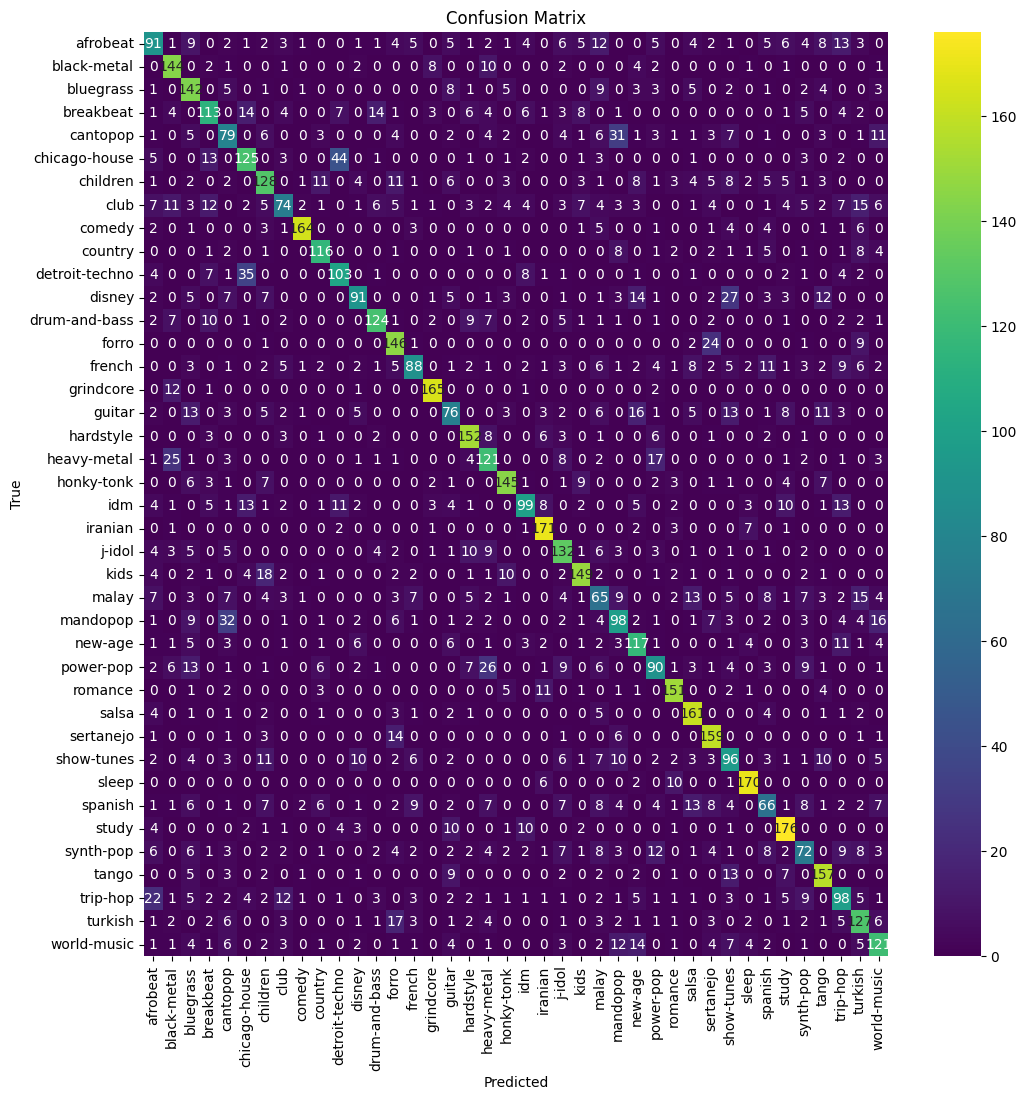

<ipython-input-38-28fe9e4471f7>:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", n_classes)


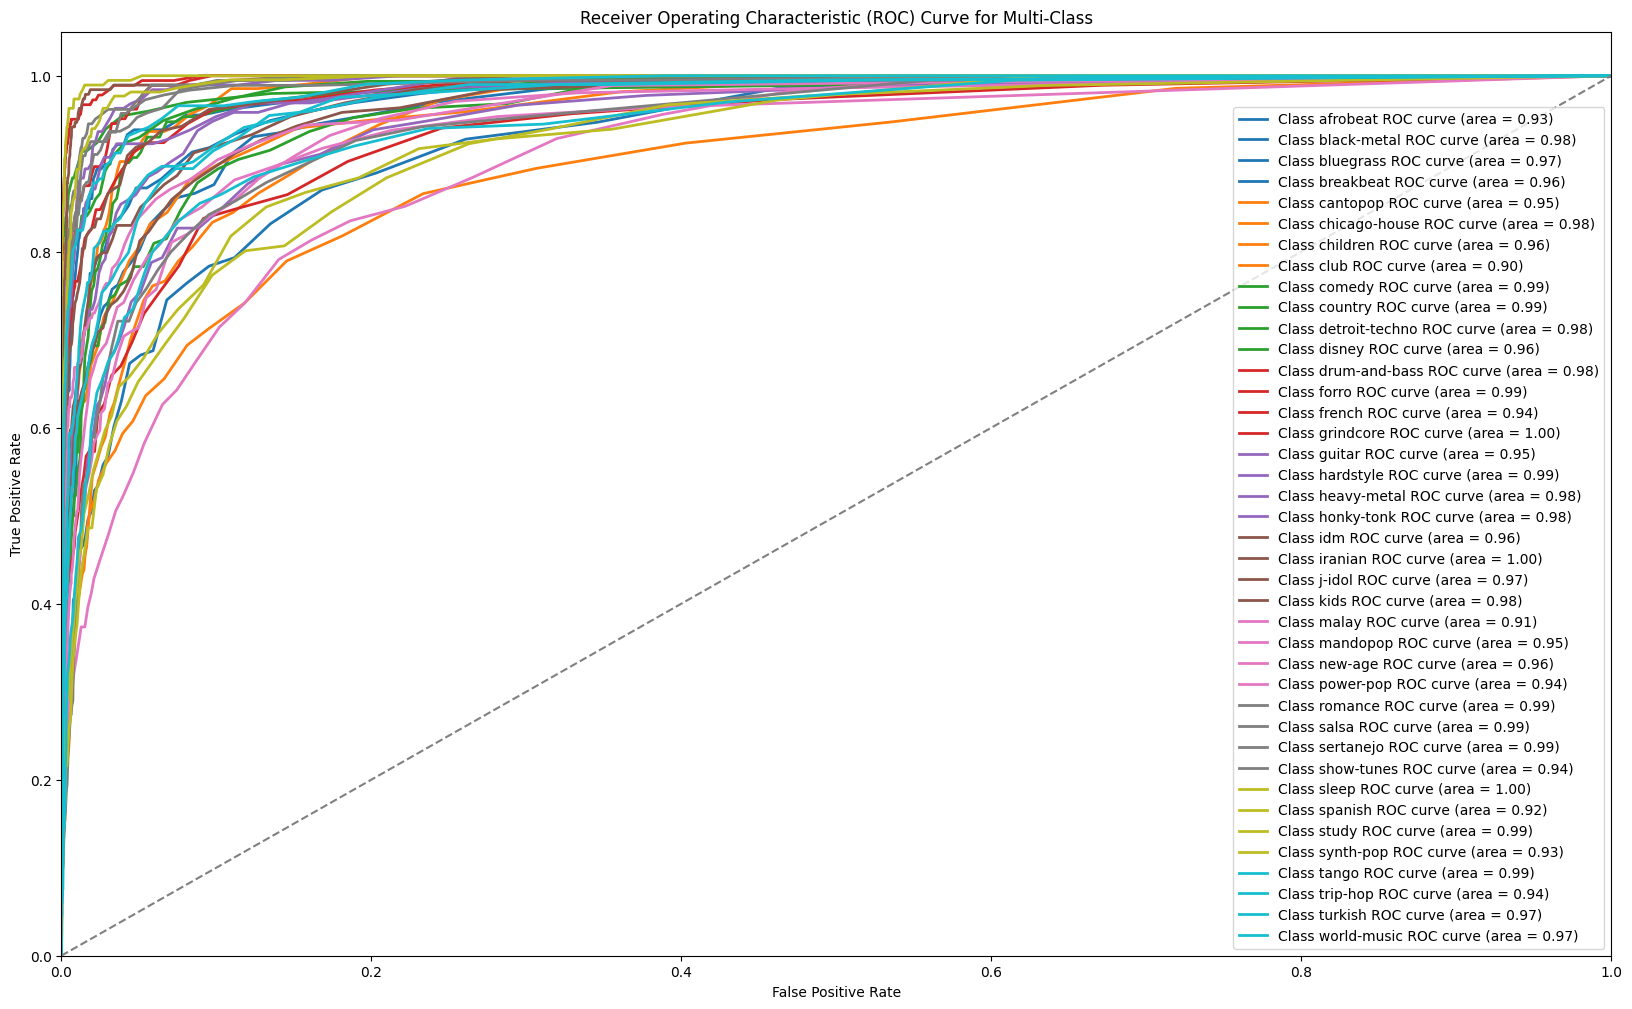

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

# Train random forest with new parameters from CV
randomForest = RandomForestClassifier(random_state=8743, n_estimators=150, min_samples_leaf=1, min_samples_split=2, max_depth=None)
randomForest.fit(x_train, y_train)
y_pred = randomForest.predict(x_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
class_names = np.unique(y_test)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=class_names)
y_pred_prob = randomForest.predict_proba(x_test)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot ROC curves
plt.figure(figsize=(20, 12))
colors = plt.cm.get_cmap("tab10", n_classes)

# Plot each class's ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'Class {class_names[i]} ROC curve (area = {roc_auc[i]:.2f})')


# Diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()
